# Exploration 9. 폐렴아 기다려라! 🤒😶‍🌫️🤨

Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia  
캐글 노트북: https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays

##  폐렴인지 아닌지에 대해 진단을 내릴 수 있는 딥러닝 모델 만들기
### 1. Set-up

In [1]:
# 패키지(라이브러리)들을 import 해오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### - 앞으로 필요한 변수들을 생성하기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개
- 비율은 89%, 10.7%, 0.3% 
#### - train에서 val 데이터 가져와서` train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### - 정상 이미지와 폐렴 이미지를 구분하기

In [5]:
# 파일 이름에 힌트 있음
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


🌀 파일 경로
- NORMAL: 정상 이미지를 셀 수 있다. 
- PNEUMONIA: 확인하면 폐렴 이미지를 셀 수 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


#### - tf.data 인스턴스 만들기
> tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 함

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### - Train 데이터셋, validation 데이터셋 개수 확인하기

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### - 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수 만들기

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

#### 1) 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이기
- `decode_img` 함수와 `process_path` 함수

#### 2) process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈 변경
- `get_label`을 이용해서 라벨 값을 가져오기

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#### - train 데이터 셋과 validation 데이터 셋 만들기
> `num_parallel_calls` 파라미터에 위에서 할당한 `AUTOTUNE`변수를 이용하면 더욱 빠르게 데이터 처리 가능

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### - 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인하기

In [12]:
for image, label in train_ds.take(1):  # train_ds.take(1): 하나의 데이터만 가져온다는 뜻
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


#### - test 데이터셋 만들고 데이터 개수 확인

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### - tf.data 파이프라인 이용
1. `prepare_for_training()` 함수를 정의해서 데이터를 변환
2. `shuffle()`을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
3. `repeat()`를 사용하면 epoch를 진행, `repeat()`를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용
    - 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.
4. `batch()`를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    - 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.
5. `prefetch()`를 사용하여 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다.   
추출된 배치를 image와 label 데이터 셋으로 나눕니다.   
`show_batch()` 함수를 이용해서 결과 사진을 보기.

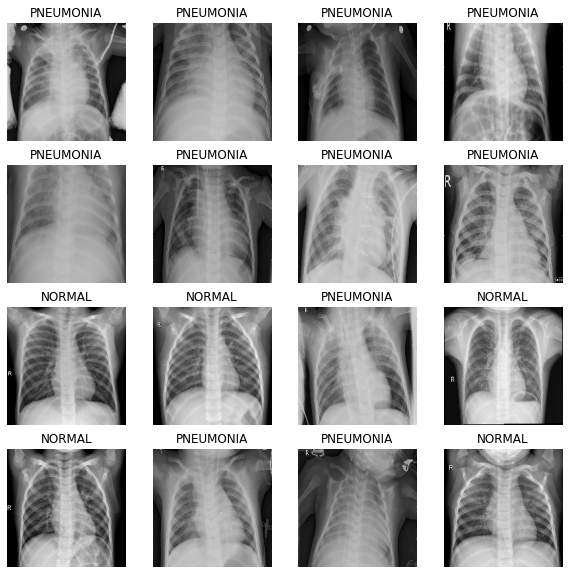

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

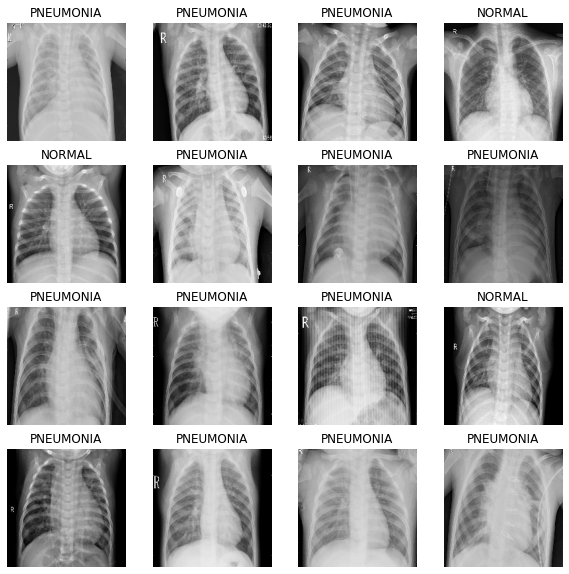

## 4. CNN 모델링
> 🌀 이미지 처리에 특화된 딥러닝 모델

- 먼저, Convolution block을 만든다.
- `conv_block()`: Convolution을 두 번 진행, Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding 해결, Max Pooling을 한다. 

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

#### - Dense Block 만들기

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

🌀 위에서 만든 CNN 모델
- Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용된다. 
> **논문 1. [Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)**  
> variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있다.  
> **논문 2.[Rethinking the Usage of Batch Normalization and Dropout in the Training of
Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)**   
>실용적으로는 두 방법을 같이 쓰는 것이 성능 향상에 도움을 주는 경우가 있다.

#### - 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부 흥미롭게 살펴보기 😊

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
🌀 **Imbalance?** 한 라벨이 너무 많은 경우, 학습 효과가 좋지 않다.

🌀 **Weight balancing?** training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

🌀 `Keras는 model.fit()`을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원한다. 

[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

#### - `weight_for_0`: 'Normal' 이미지에 사용할 weight를, `weight_for_1`: 'Pneumonia' 이미지에 사용할 weight를 세팅하기
> weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
> 1. 이미지 훈련은 GPU를 사용할 것이기 때문에 GPU 선택  
2. 모델은 위에서 만들었던 모델 함수인 `build_model()`을 model에 선언
3. 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
4.  optimizer로 'adam' 사용
5. 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### - 모델 fit하기
파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어준다 **(약 20분 소요)**

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 85s 192ms/step - loss: 0.3733 - accuracy: 0.8240 - precision: 0.9633 - recall: 0.7937 - val_loss: 0.6596 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2329 - accuracy: 0.9088 - precision: 0.9729 - recall: 0.9024 - val_loss: 1.0403 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1989 - accuracy: 0.9210 - precision: 0.9763 - recall: 0.9160 - val_loss: 0.3770 - val_accuracy: 0.8115 - val_precision: 0.7960 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1871 - accuracy: 0.9262 - precision: 0.9781 - recall: 0.9215 - val_loss: 0.0765 - val_accuracy: 0.9740 - val_precision: 0.9707 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1569 - accura

## 7. 결과 확인
#### - 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여주기

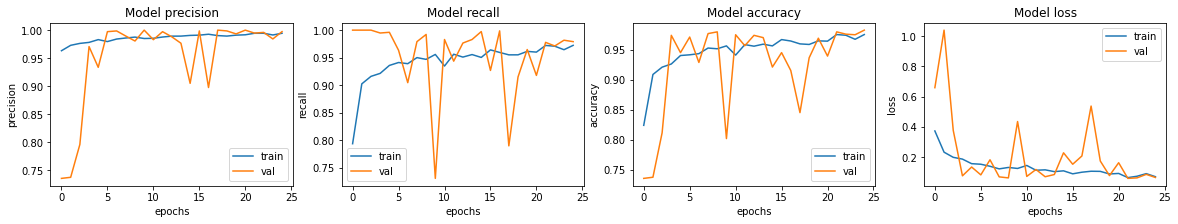

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### - 테스트 데이터로 모델 평가하기
loss, accuracy, precision, recall 값을 출력해보기

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.1507 - accuracy: 0.7837 - precision: 0.7429 - recall: 1.0000
Loss: 1.1506608724594116,
Accuracy: 0.7836538553237915,
Precision: 0.7428571581840515,
Recall: 1.0


### 페렴 진단에 있어서 약 80% 이상 정확도 😶‍🌫️

#### 💗 성능 개선 방안 💗
> 의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있습니다.   
> 🌟 이를 해결하기 위해 **Data augmentation** 방법 시도 !!! 🌟
- 이미지 회전, 가우시안 노이즈 추가 방법 등을 많이 사용
- 전통적인 Data augmentation 방법 이외에도 GAN을 이용해서 Data augmentation을 시도하는 연구들도 많이 있으니 참고